In [1]:
import numpy as np
import pandas as pd
from scipy.stats import chi2_contingency

In [2]:
import matplotlib.pyplot as plt

# Generate synthetic data
np.random.seed(42)
X = np.concatenate([np.random.normal(5, 2, 100), np.random.normal(15, 2, 100)])
y = np.concatenate([np.zeros(180), np.ones(20)])

# Shuffle the data
shuffle_indices = np.random.permutation(len(X))
X = X[shuffle_indices]
y = y[shuffle_indices]

In [3]:
def chi2_optimal_binning(X, y, max_bins=4, min_bin_size=5):
    # Initial sorting of the data
    sorted_indices = np.argsort(X)
    X_sorted = pd.Series(X[sorted_indices])
    y_sorted = pd.Series(y[sorted_indices])

    num_bins = 2
    bins = [X_sorted.min()]

    while num_bins < max_bins:
        # Calculate contingency table for each potential split point
        chi2_values = []
        for i in range(1, len(X_sorted)):
            split_point = X_sorted[i]
            X_splited=X_sorted.apply(lambda x : 1 if x> split_point else 0)
            table = pd.crosstab(X_splited, y_sorted)
            chi2, _, _, _ = chi2_contingency(table)
            chi2_values.append(chi2)

        # Find the split point with the maximum chi2 value
        best_chi2_index = np.argmax(chi2_values)
        best_chi2_value = chi2_values[best_chi2_index]
        best_split_point = X_sorted[best_chi2_index + 1]  # Right edge of the bin

        # Check if the chi2 value is significant and if the bin size is above the threshold
        # if best_chi2_value > 0 and np.min([len(table[0]) for table in contingency_tables]) > min_bin_size:
        #     bins.append(best_split_point)
        #     num_bins += 1
        #     X_sorted = X_sorted[X_sorted > best_split_point]
        #     y_sorted = y_sorted[X_sorted > best_split_point]
        # else:
        #     break
        num_bins+=1
    bins.append(X_sorted.max())
    return best_split_point

# Example usage:
# Assuming you have a DataFrame 'df' with a continuous variable 'X' and a binary target 'y'
# bins = chi2_optimal_binning(df['X'].values, df['y'].values, max_bins=5, min_bin_size=5)
# print("Optimal bins:", bins)


In [4]:
df = pd.DataFrame({'X': X, 'y': y})

In [5]:
from optbinning import OptimalBinning

(CVXPY) Feb 20 03:07:51 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.8.3296). Expected < 9.8.0. Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Feb 20 03:07:51 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.8.3296). Expected < 9.8.0. Please open a feature request on cvxpy to enable support for this version.')


In [6]:
optb = OptimalBinning(name="X", dtype="numerical", solver="cp", min_bin_size=0.05)
optb.fit(df['X'], df['y'])

OptimalBinning(min_bin_size=0.05, name='X')

In [7]:
from tabulate import tabulate
from collections import Counter
import warnings
warnings.filterwarnings("ignore")

In [8]:
class ChiMergeDiscretizer:
    
    def __init__(self) -> None:
        pass
    
    def get_new_intervals(self,intervals, chi, min_chi):
        '''To merge the interval based on minimum chi squre value'''
        
        min_chi_index=np.where(chi==min_chi)[0][0]
        new_intervals=[]
        skip=False
        done=False
        for i in range(len(intervals)):
            if skip:
                skip=False
                continue
            if i==min_chi_index and not done:
                t= intervals[i] + intervals[i+1]
                new_intervals.append([min(t), max(t)])
                skip=True
                done=True
            else:
                new_intervals.append(intervals[i])
        return new_intervals
    
    def get_chi_merged_intervals(self, data,colname,label, max_intervals):
        """
        1. Compute the chi2 value for each pair of adjacent intervals
        2. Merge the pair of adjacent intervals with the lowest chi2 value
        3. Repeat 1 and 2 until chi2 values of all adjacent pairs exceeds a threshold

        Args:
            data (_type_): _description_
            colname (_type_): _description_
            label (_type_): _description_
            max_intervals (_type_): _description_
        """
        
        distinct_vals=np.unique(data[colname])
        labels = np.unique(data[label])
        # Initially set the value to zero for all unique output column values
        empty_count = {l: 0 for l in labels}
        intervals = [[distinct_vals[i], distinct_vals[i]] for i in range(len(distinct_vals))]
        while len(intervals) > max_intervals:
            chi = []
            for i in range(len(intervals)-1):
                
                # Find chi square for Interval 1
                row1 = data[data[colname].between(intervals[i][0], intervals[i][1])]
                # Find chi square for Interval 2
                row2 = data[data[colname].between(intervals[i+1][0], intervals[i+1][1])]
                total = len(row1) + len(row2)
                
                # Generate Contigency
                count_0 = np.array([v for i, v in {**empty_count, **Counter(row1[label])}.items()])
                count_1 = np.array([v for i, v in {**empty_count, **Counter(row2[label])}.items()])
                count_total = count_0 + count_1
                
                # Find the expected value by the following formula
                # Expected Value → ( Row Sum * Column Sum ) / Total Sum
                expected_0 = count_total*sum(count_0)/total
                expected_1 = count_total*sum(count_1)/total
                chi_ = (count_0 - expected_0)**2/expected_0 + (count_1 - expected_1)**2/expected_1
                
                # Store the chi value to find minimum chi value
                chi_ = np.nan_to_num(chi_)
                chi.append(sum(chi_))
            min_chi = min(chi)
            
            intervals = self.get_new_intervals(intervals, chi, min_chi)
        print(' Min chi square value is ' + str(min_chi))
        return intervals
        

In [9]:
disc=ChiMergeDiscretizer()

In [10]:
intervals = disc.get_chi_merged_intervals(df, "X", "y", max_intervals=4)
print(tabulate([[intervals]], tablefmt='fancy_grid'))

 Min chi square value is 2.8531468531468533
╒═══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╕
│ [[-0.23949020817948874, 11.898673137867736], [11.970305550628272, 13.220971140748954], [13.232285127597734, 13.30641256386319], [13.358635363296578, 20.440338333179238]] │
╘═══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╛


Optimal bins (OptimalBinning): [12.78613758 14.85272551 15.44155359 16.4659338 ]


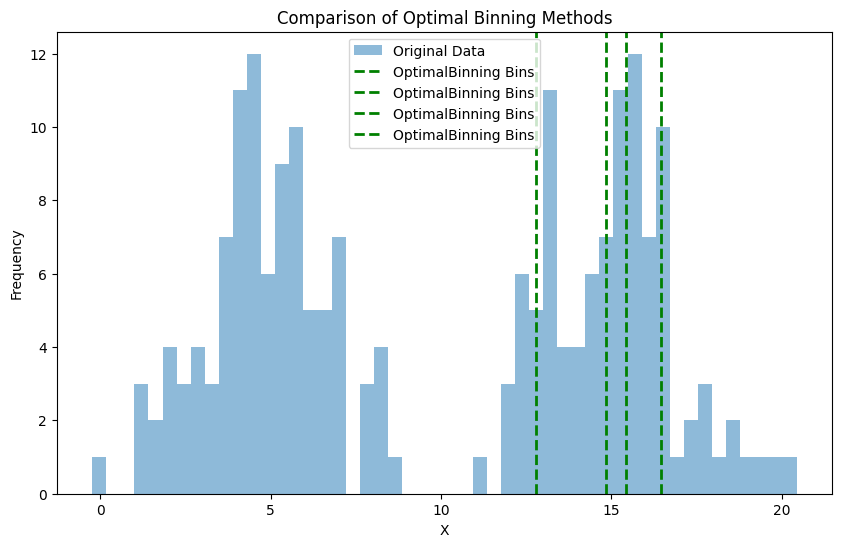

In [11]:

# Display the optimal bins from OptimalBinning
print("Optimal bins (OptimalBinning):", optb.splits)

# Plot the original data and bin edges
plt.figure(figsize=(10, 6))
plt.hist(X, bins=50, alpha=0.5, label='Original Data')

for bin_edge in optb.splits:
    plt.axvline(bin_edge, color='green', linestyle='dashed', linewidth=2, label='OptimalBinning Bins')
plt.title('Comparison of Optimal Binning Methods')
plt.xlabel('X')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [15]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np

# Génération de données d'exemple (remplacez X1 et y par vos propres données)
X1 = np.random.normal(loc=0, scale=1, size=(100, 1))  # Variable continue choisie comme prédicteur unique
y = (np.random.normal(size=(100, 1)) > 0.5).astype(int)  # Variable binaire aléatoire

# Séparation des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=0.2, random_state=42)

# Création d'un classifieur d'arbre de décision avec une profondeur maximale de 2
clf = DecisionTreeClassifier(max_depth=2, )

# Entraînement du classifieur sur les données d'entraînement
clf.fit(X_train, y_train)

# Prédictions sur les données de test
y_pred = clf.predict(X_test)

# Évaluation de l'exactitude du classifieur
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.65


[Text(0.4, 0.8333333333333334, 'x[0] <= -1.17\ngini = 0.42\nsamples = 80\nvalue = [56, 24]'),
 Text(0.2, 0.5, 'gini = 0.0\nsamples = 6\nvalue = [6, 0]'),
 Text(0.6, 0.5, 'x[0] <= -0.993\ngini = 0.438\nsamples = 74\nvalue = [50, 24]'),
 Text(0.4, 0.16666666666666666, 'gini = 0.0\nsamples = 2\nvalue = [0, 2]'),
 Text(0.8, 0.16666666666666666, 'gini = 0.424\nsamples = 72\nvalue = [50, 22]')]

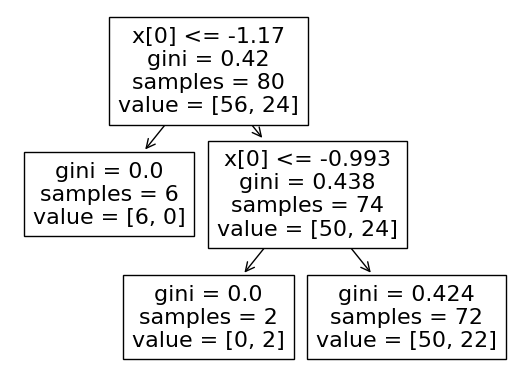

In [16]:
from sklearn.tree import plot_tree
plot_tree(clf)

In [19]:
clf.tree_.threshold

array([-1.17036152, -2.        , -0.99342501, -2.        , -2.        ])

In [73]:
from sklearn.tree import DecisionTreeClassifier
class DecisionTreeDiscretizer:
    def __init__(self, max_bins=4):
        self.tree_max_depth=max_bins//2
        pass
    
    def get_thresholds(self, X_train, y_train):
        clf=DecisionTreeClassifier(criterion="gini",max_depth=self.tree_max_depth, min_samples_leaf=0.05)
        clf.fit(X_train,y_train)
        thresholds_np=None
        thresholds=[-np.inf]+sorted(list(set(list(thresholds_np))))+[np.inf]
        return thresholds


In [74]:
X = 1000 * np.random.rand(100, 1)

# Création d'une variable binaire y de manière arbitraire
# Dans cet exemple, y est basé sur une condition aléatoire
y = (np.random.rand(100, 1) > 0.7).astype(int)

In [75]:
disc=DecisionTreeDiscretizer()

In [76]:
thresholds=disc.get_thresholds(X,y)

In [77]:
X_df=pd.DataFrame(X, columns=["X"])

In [80]:
X_cutted=pd.cut(X_df["X"],bins=thresholds)

In [84]:
type(X_cutted)

pandas.core.series.Series

In [85]:
pd.crosstab(X_cutted,pd.Series(y.flatten()))

col_0,0,1
X,,
"(-2.0, 515.663]",27,22
"(515.663, 538.191]",1,4
"(538.191, 939.444]",30,10
"(939.444, inf]",6,0


In [72]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score

class DecisionTreeDiscretizer:
    def __init__(self, max_bins=5, target=None):
        self.tree_max_bins = max_bins
        self.clf = DecisionTreeClassifier(criterion="gini", max_depth=self.tree_max_bins//2,
                                          min_samples_split=0.05, min_samples_leaf=0.05)
        self.target = target

    def fit(self, X_train):
        # Entraîner le modèle sur les données d'entraînement
        self.clf.fit(X_train.values.reshape(-1, 1), self.target)

    def _get_tree_thresholds(self):
        thresholds = set()
        for node in range(self.clf.tree_.node_count):
            if self.clf.tree_.children_left[node] != self.clf.tree_.children_right[node]:  # non-leaf node
                feature = self.clf.tree_.feature[node]
                threshold = self.clf.tree_.threshold[node]
                thresholds.add(threshold)
        return np.array(list(thresholds))

    def get_thresholds(self):
        if hasattr(self.clf, 'tree_') and self.clf.tree_ is not None:
            thresholds_np = self._get_tree_thresholds()
            thresholds = [-np.inf] + sorted(list(set(list(thresholds_np)))) + [np.inf]
            return thresholds
        else:
            raise ValueError("Le classifieur n'est pas entraîné. Utilisez la méthode fit avant d'obtenir les seuils.")

    def transform(self, X):
        # Vérifier si le modèle est entraîné
        if not hasattr(self.clf, 'tree_') or self.clf.tree_ is None:
            raise ValueError("Le classifieur n'est pas entraîné. Utilisez la méthode fit avant de transformer les données de test.")

        thresholds = self.get_thresholds()

        # Utiliser pd.cut pour obtenir les intervalles au lieu des numéros
        intervals = pd.cut(X.values.flatten(), bins=thresholds, include_lowest=True, right=True)
        return intervals



In [73]:

# Exemple d'utilisation
# Génération de données d'exemple (remplacez data par vos propres données)
data = pd.DataFrame({
    'X': np.random.rand(100),
    'Y': (np.random.rand(100) > 0.5).astype(int)
})

# Instanciation de la classe DecisionTreeDiscretizer
dt_discretizer = DecisionTreeDiscretizer(max_bins=4, target=data["Y"])

# Entraînement du modèle
dt_discretizer.fit(data["X"])

# Obtention des seuils
thresholds = dt_discretizer.get_thresholds()
print("Seuils obtenus à partir de l'arbre de décision:", thresholds)

# Discrétisation des données de test
discretized_test = dt_discretizer.transform(data["X"])
print("\nDonnées de test discrétisées (intervalles):", discretized_test)

Seuils obtenus à partir de l'arbre de décision: [-inf, 0.36812514066696167, 0.5546557307243347, 0.6203245222568512, inf]

Données de test discrétisées (intervalles): [(-inf, 0.368], (0.62, inf], (-inf, 0.368], (0.62, inf], (0.62, inf], ..., (-inf, 0.368], (-inf, 0.368], (0.62, inf], (0.62, inf], (0.368, 0.555]]
Length: 100
Categories (4, interval[float64, right]): [(-inf, 0.368] < (0.368, 0.555] < (0.555, 0.62] < (0.62, inf]]


In [74]:
# Discrétisation des données de test
data["X_dis"] = dt_discretizer.transform(data["X"])

In [75]:
data

,X,Y,X_dis
0,0.082172,0,"(-inf, 0.368]"
1,0.967860,1,"(0.62, inf]"
2,0.295445,1,"(-inf, 0.368]"
3,0.769223,1,"(0.62, inf]"
4,0.624664,0,"(0.62, inf]"
...,...,...,...
95,0.148888,0,"(-inf, 0.368]"
96,0.305604,0,"(-inf, 0.368]"
97,0.876651,0,"(0.62, inf]"
98,0.996334,1,"(0.62, inf]"


In [76]:
# ... (le reste du code)


print("\nDonnées de test discrétisées (intervalles):", discretized_test)

# Création d'une crosstab pour vérifier la distribution
crosstab_result = pd.crosstab(index=discretized_test, columns=data["Y"], margins=True, margins_name="Total")
print("\nCrosstab de la discrétisation par rapport à la variable cible:\n", crosstab_result)



Données de test discrétisées (intervalles): [(-inf, 0.368], (0.62, inf], (-inf, 0.368], (0.62, inf], (0.62, inf], ..., (-inf, 0.368], (-inf, 0.368], (0.62, inf], (0.62, inf], (0.368, 0.555]]
Length: 100
Categories (4, interval[float64, right]): [(-inf, 0.368] < (0.368, 0.555] < (0.555, 0.62] < (0.62, inf]]

Crosstab de la discrétisation par rapport à la variable cible:
 Y                0   1  Total
row_0                        
(-inf, 0.368]   21  13     34
(0.368, 0.555]  12   2     14
(0.555, 0.62]    1   7      8
(0.62, inf]     20  24     44
Total           54  46    100
